In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

## Particle deflection calculation
The magnet will deflect an electron of momentum $p$ (in eV/c) according to:

$\theta = \frac{cBd}{p}$

where $Bd$ is the integrated field of the magnet. The horizontal displacement from the beam a distance $l$ down the beamline will be

$\Delta x = l\cdot\tan\theta = l\cdot\tan\Bigr(\frac{cBd}{p}\Bigr)$.

The integrated field for our magnet is $Bd = 0.23\,T\cdot m$.

In [2]:
# Hodoscope parameters
hodo_x_len = 4.2   # Length in x (transverse) direction (cm)
hodo_z_len = 2.0   # Length in z (downstream) direction (cm)
hodo_x_sep = 7.55  # Separation in x (transverse) direction (cm)
hodo_z_sep = 17.0  # Separation in z (downstream) direction (cm)

# Hodoscope positions from MC (in cm)
hodoscope_positions = { 0: (86.9258, 183.884),
                        1: (87.5694, 202.285),
                        2: (79.411,  185.779),
                        3: (80.0546, 204.18),
                        4: (71.8963, 187.674),
                        5: (72.5398, 206.075),
                        6: (64.3815, 189.569),
                        7: (65.025, 207.97),
                        8: (56.8667, 191.464),
                        9: (57.5102, 209.865),
                       10: (49.3519, 193.359),
                       11: (49.9954, 211.76),
                       12: (41.8371, 195.253),
                       13: (42.4806, 213.655),
                       14: (34.3223, 197.148)}

# location of end of magnet in MC (in cm)
end_of_magnet_offset = 7.5

# Maximum length for showing positron path
l_max = 250

# Constants and field
c = 2.99792458e8
Bd = 0.23

### Beam configuration (*fig.beamconfig*)

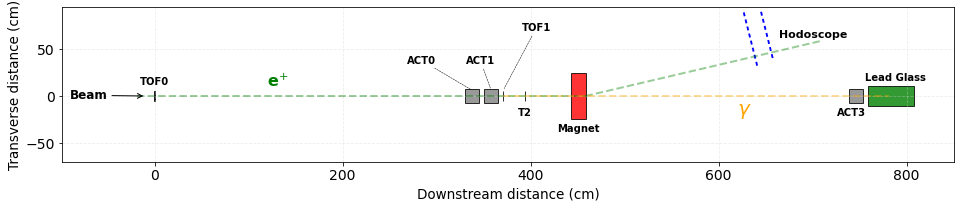

In [3]:
# Helper function to add a callout label
def add_callout_label(ax, point, end, label, labelsize, text_offset=(0,0)):
    ax.annotate(label, 
                xy=point,
                xytext=end,
                arrowprops=dict(arrowstyle='-',linestyle='--',linewidth=0.5,facecolor='black'), # adjust line width and color
                fontsize=labelsize,
                fontweight='bold')

# Detectors to be placed on the drawing
detectors = [
    {'label': 'TOF0', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 15, 'lzoffset': 0, 'center': (0, -450.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'ACT0', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -112.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'ACT1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -92.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'TOF1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -80.1), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'T2',   'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': 0, 'center': (0, -56.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'Magnet', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -35, 'lzoffset': 0, 'center': (0, 0), 'x_length': 48, 'z_length': 15, 'color': 'red'},
    {'label': 'ACT3', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': -5, 'center': (0, 295.1), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'Lead Glass', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 20, 'lzoffset': 5, 'center': (0, 332.35), 'x_length': 20.5, 'z_length': 49.5, 'color': 'green'}
]

xoffset = -450.9

fig, ax = plt.subplots(figsize=(16, 6))
fig.set_facecolor('white')

ax.set_xlim([-550-xoffset,400-xoffset])
ax.set_ylim([-70,95])

# Add gridlines
ax.grid(True, which='both', color='lightgray', alpha=0.4, linestyle='--')

# Add the detectors
for detector in detectors:
    y, x = detector['center']
    x_len, z_len = detector['x_length'], detector['z_length']
    rect = patches.Rectangle((x - z_len/2 - xoffset, y - x_len/2), z_len, x_len, 
                             edgecolor='black', facecolor=detector['color'], alpha=0.8)
    ax.add_patch(rect)
    
    if(not detector['labelcallout']):
        ax.text(x+detector['lzoffset']-xoffset, y+detector['lxoffset'], detector['label'], ha='center', 
                va='center', color='black', fontweight='bold', fontsize=detector['labelsize'], rotation=detector['labelrot'])

# Hodoscope label
ax.text(250-xoffset, 65, "Hodoscope", ha='center', va='center', color='black', fontweight='bold', fontsize=11)

# ACT0 callout label
point_ACT0 = (-112.9-xoffset, 6)
end_ACT0 = (-182.9-xoffset, 35)
add_callout_label(ax, point_ACT0, end_ACT0, "ACT0", detectors[1]['labelsize'], text_offset=(0,30))

# ACT1 callout label
point_ACT1 = (-92.9-xoffset, 6)
end_ACT1 = (-120-xoffset, 35)
add_callout_label(ax, point_ACT1, end_ACT1, "ACT1", detectors[2]['labelsize'], text_offset=(0,30))

# TOF1 callout label
point_TOF1 = (-80.1-xoffset,6)
end_TOF1 = (-60.1-xoffset,70)
add_callout_label(ax, point_TOF1, end_TOF1, "TOF1", detectors[3]['labelsize'], text_offset=(0,30))

# Beam annotation
ax.annotate("Beam", xy=(-10, 0), xytext=(-90, -3),
                arrowprops=dict(arrowstyle='->',facecolor='black'), # adjust line width and color
                fontsize=12,
                fontweight='bold')
    
# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

for i in range(7):  # Second row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

# ------------------------------------------------------------------------------------------------------
# Plot the e+ and gamma tracks

# e+ along the beam
x_values = np.zeros(100)
z_values = np.linspace(-470, 7.5, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='green')
ax.annotate("e$^{+}$", xy=(120, 10), xytext=(120, 10), fontsize=16, fontweight='bold', color='green')

# e+ after interaction in the magnet.
p_particle = 300
theta = Bd / (p_particle * 1e6 / c)  # calculate the angle at which the particle exits the magnetic field
z_values = np.linspace(0, l_max, 100)
dX_values = z_values * np.tan(theta)
ax.plot(z_values-xoffset+7.5, dX_values, linestyle='--', linewidth=2, alpha=0.4, color='green')

# gamma path
x_values = np.zeros(100)
z_values = np.linspace(-80.1, 330, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='orange')
ax.annotate("$\gamma$", xy=(320, 10), xytext=(620, -20), fontsize=20, fontweight='bold', color='orange')

# ------------------------------------------------------------------------------------------------------
    
# Add a legend
#ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance (cm)',fontsize=13.5)
ax.set_ylabel('Transverse distance (cm)',fontsize=13.5)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("beamline.pdf", bbox_inches='tight')

### Calculation of energy for each hodoscope position (for use in *fig.LG_calibration*)

In [4]:
momenta_c = {}
momenta_l, momenta_r = {}, {}
momenta_delta = {}
for elem, (x, z) in hodoscope_positions.items():

    z -= end_of_magnet_offset*2
    
    # Calculate the angle theta
    theta_c = np.arctan2(x, z)
    theta_l = np.arctan2(x+hodo_x_len/2, z)
    theta_r = np.arctan2(x-hodo_x_len/2, z)

    # Calculate the momentum in GeV/c
    p_c = Bd * c / theta_c / 1e9  # convert to GeV/c from kg*m/s
    p_l = Bd * c / theta_l / 1e9
    p_r = Bd * c / theta_r / 1e9
    
    # Store the calculations
    momenta_c[elem] = p_c
    momenta_l[elem] = p_l
    momenta_r[elem] = p_r
    momenta_delta[elem] = p_r - p_l

In [5]:
print("Approx. momentum range due to size of hodoscope elements:")
for elem in momenta_c.keys():
    p_deltac = momenta_delta[elem]/momenta_c[elem]
    print("-- Elem {}, range = {}, range/mean = {}".format(elem,momenta_delta[elem],p_deltac))

Approx. momentum range due to size of hodoscope elements:
-- Elem 0, range = 0.006003478040787047, range/mean = 0.0413868506335437
-- Elem 1, range = 0.00663729973711355, range/mean = 0.04210105577484878
-- Elem 2, range = 0.00736537624991454, range/mean = 0.046492928353344815
-- Elem 3, range = 0.008107593837929694, range/mean = 0.04707029195603055
-- Elem 4, range = 0.009190736655809384, range/mean = 0.05258853956415671
-- Elem 5, range = 0.010071346615116883, range/mean = 0.05299629857876715
-- Elem 6, range = 0.011710541962637738, range/mean = 0.060007344338335315
-- Elem 7, range = 0.01277173351075328, range/mean = 0.06020197449583076
-- Elem 8, range = 0.015319172071836973, range/mean = 0.06926141096379354
-- Elem 9, range = 0.016621962079086255, range/mean = 0.06918112640989577
-- Elem 10, range = 0.020735616861404627, range/mean = 0.08117924738042342
-- Elem 11, range = 0.022370514673047126, range/mean = 0.08072829003496729
-- Elem 12, range = 0.02938524946620763, range/mean = 

In [6]:
#momenta_delta
momenta_c

{0: 0.14505761972430145,
 1: 0.15765162214954906,
 2: 0.15841928032448094,
 3: 0.17224439239729353,
 4: 0.17476691180208406,
 5: 0.19003867977964684,
 6: 0.19515181169509832,
 7: 0.21214808347586303,
 8: 0.221179035463847,
 9: 0.24026729458843601,
 10: 0.2554300209785521,
 11: 0.2771087392456521,
 12: 0.3023374084001211,
 13: 0.3273027027261406,
 14: 0.37021942607830755}

In [7]:
# Momentum for hitting lead glass
theta_LG = np.arctan2(12, 250)
p_LG = Bd * c / theta_LG / 1e9
p_LG

1.4376080871505792

---

## Plots of magnetic field map

In [8]:
# Read the field map.
df = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', header=None)

# Assign column names
df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

# Compute the magnitude of the field
df['Bmag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

df.head(20)

,x,y,z,Bx,By,Bz,Bmag
0,-15.0,-15.0,-315.0,0.0,0.0,0.0,0.0
1,-12.5,-15.0,-315.0,0.0,0.0,0.0,0.0
2,-10.0,-15.0,-315.0,0.0,0.0,0.0,0.0
3,-7.5,-15.0,-315.0,0.0,0.0,0.0,0.0
4,-5.0,-15.0,-315.0,0.0,0.0,0.0,0.0
5,-2.5,-15.0,-315.0,0.0,0.0,0.0,0.0
6,0.0,-15.0,-315.0,0.0,0.0,0.0,0.0
7,2.5,-15.0,-315.0,0.0,0.0,0.0,0.0
8,5.0,-15.0,-315.0,0.0,0.0,0.0,0.0
9,7.5,-15.0,-315.0,0.0,0.0,0.0,0.0


In [9]:
len(df['y'].unique())

13

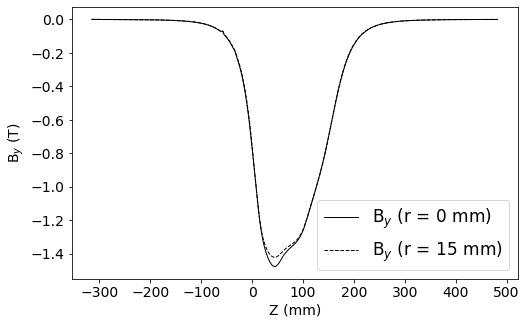

In [10]:
df_center = df[(df['y'] == 0) & (df['x'] == 0)]
df_r1 = df[(df['y'] == 0) & (df['x'] == 15.0)]

# Central axis
By_center = df_center['By'].values
z_center  = df_center['z'].values

# Off-axis near smallest bore edge
By_r1 = df_r1['By'].values
z_r1  = df_r1['z'].values

plt.figure(figsize=(8,5))
plt.plot(z_center,By_center,linewidth=1,color='black',label="B$_y$ (r = 0 mm)")
plt.plot(z_r1,By_r1,linewidth=1,color='black',linestyle='--',label="B$_y$ (r = 15 mm)")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{y}$ (T)',fontsize=14)
plt.legend(fontsize=17,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [11]:
print(z_center[By_center < -1.35])

[25.  27.5 30.  32.5 35.  37.5 40.  42.5 45.  47.5 50.  52.5 55.  57.5
 60.  62.5 65.  67.5 70.  72.5 75.  77.5 80. ]


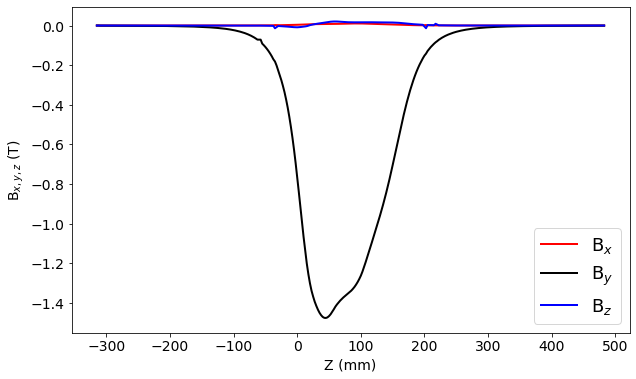

In [12]:
df_filtered = df[(df['y'] == 0) & (df['x'] == 0)]
Bx = df_filtered['Bx'].values
By = df_filtered['By'].values
Bz = df_filtered['Bz'].values
z  = df_filtered['z'].values

plt.figure(figsize=(10,6))
plt.plot(z,Bx,linewidth=2,color='red', label="B$_x$")
plt.plot(z,By,linewidth=2,color='black', label="B$_y$")
plt.plot(z,Bz,linewidth=2,color='blue', label="B$_z$")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{x,y,z}$ (T)',fontsize=14)
plt.legend(fontsize=18,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [13]:
Bd = np.trapz(z_center,By_center)/1000
print(f"Integrated field By = {Bd} T*m")

Integrated field By = 0.226636530315 T*m


Text(0.5, 0, 'z (mm)')

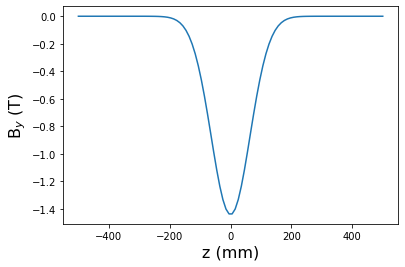

In [14]:
# Geant4 field
z = np.linspace(-500,500,100)
fwhm_to_sigma = (2*(2*np.log(2))**0.5)
sigma = 150 / fwhm_to_sigma
bfield = -1.441*np.exp(-z**2/(2*sigma**2))
plt.plot(z,bfield)
plt.ylabel("B$_y$ (T)",fontsize=16)
plt.xlabel("z (mm)",fontsize=16)
#print(f"FWHM to sigma conversion factor: {fwhm_to_sigma}")

In [15]:
Bd_sim = np.trapz(z,bfield)/1000
print(f"Integrated field simulated in Geant4 = {Bd_sim} T*m")

Integrated field simulated in Geant4 = 0.23008454624999825 T*m


#### 2D plots

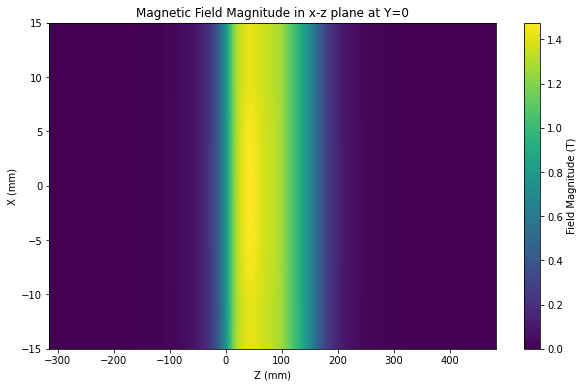

In [16]:
# Filter dataframe for a specific y-plane, for example, y=0
y_plane = 0
#df_filtered = df[(df['y'] == y_plane) & (df['z'] > -100) & (df['z'] < 250)]
df_filtered = df[df['y'] == y_plane]

# Create a pivot table for the magnitude values
pivot = df_filtered.pivot(index='x', columns='z', values='Bmag').fillna(0)

# Create the heatmap
plt.figure(figsize=(10,6))
plt.imshow(pivot, aspect='auto', cmap='viridis', origin='lower', 
           extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
plt.colorbar(label='Field Magnitude (T)')
plt.title(f'Magnetic Field Magnitude in x-z plane at Y={y_plane}')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')
plt.show()

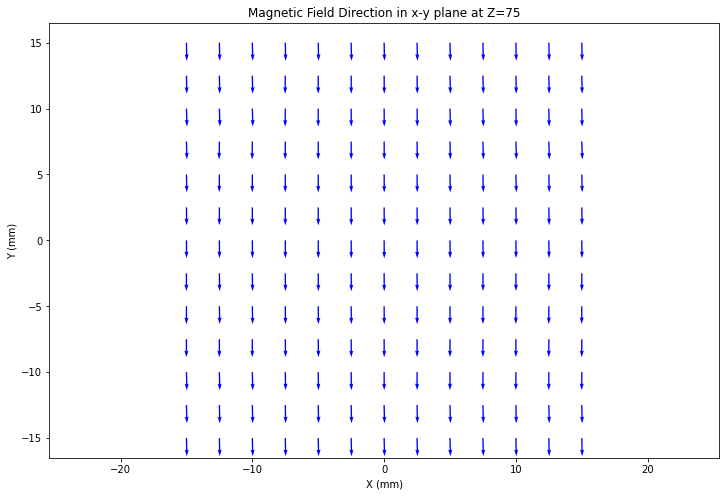

In [17]:
# Filter dataframe for a specific z-plane, e.g., z=0
z_plane = 75
df_filtered = df[df['z'] == z_plane]
arrow_scale = 1

# Create the quiver (arrow) plot
plt.figure(figsize=(12,8))
plt.quiver(df_filtered['x'], df_filtered['y'], arrow_scale*df_filtered['Bx'], arrow_scale*df_filtered['By'], 
           angles='xy', scale_units='xy', scale=1, color='blue', width=0.002)
plt.title(f'Magnetic Field Direction in x-y plane at Z={z_plane}')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.axis('equal')
plt.show()


##### Extend the magnetic field

In [ ]:
data = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', 
                   header=None, names=['X', 'Y', 'Z', 'Bx', 'By', 'Bz'])

# Generate additional points
new_points_range = np.arange(-40, 40.1, 2.5)  # Including +/- 40 mm with a step size of 2.5 mm

# Initialize a list to collect new rows
new_rows = []

# Magnet radii
r1 = 30  # mm; bore radius 1 = 23
r2 = 40  # mm; bore radius 2 = 31
r3 = 45  # mm; bore radius 3 = 40
deltaZ = 50 # mm; length of one magnet segment (3 in total)

ipt = 0
zpoints = data['Z'].unique()
npts = len(zpoints)*len(new_points_range)**2
for z in zpoints:
    # Find the set of existing X and Y for this Z to avoid duplicates
    existing_xy = data[data['Z'] == z][['X', 'Y']].drop_duplicates()

    for x in new_points_range:
        for y in new_points_range:
            # Check if this X, Y combination is new
            if not ((existing_xy['X'] == x) & (existing_xy['Y'] == y)).any():
                # Find the closest existing point in the original data for this Z
                # Using Euclidean distance for simplicity; this could be adjusted as needed
                distances = np.sqrt((data['X'] - x)**2 + (data['Y'] - y)**2 + (data['Z'] - z)**2)
                closest_index = distances.idxmin()
                closest_point = data.loc[closest_index]
                
                # Ensure the field is within the allowed region.
                isInside = False
                r = (x**2 + y**2)**0.5
                if (z <= 0                         and r <= r1): isInside = True  # pre-magnet
                if (z > 0        and z < deltaZ    and r <= r1): isInside = True  # region 1
                if (z > deltaZ   and z <= 2*deltaZ and r <= r2): isInside = True  # region 2
                if (z > 2*deltaZ and z <= 3*deltaZ and r <= r3): isInside = True  # region 3
                if (z > 3*deltaZ                   and r <= r3): isInside = True  # post-magnet
                
                # Set the field.
                if(isInside):
                    Bx = closest_point['Bx']
                    By = closest_point['By']
                    Bz = closest_point['Bz']
                    #print(f"Adding field {Bx},{By},{Bz} at ({x},{y},{z}) with closest point {closest_point['X']},{closest_point['X']},{closest_point['X']}")
                else:
                    Bx = 0
                    By = 0
                    Bz = 0

                # Create a new row with this X, Y, Z and the Bx, By, Bz from the closest point
                new_row = {'X': x, 'Y': y, 'Z': z, 'Bx': Bx, 'By': By, 'Bz': Bz}
                new_rows.append(new_row)
                
            ipt += 1
            if(ipt % 1000 == 0):
                print(f"[pt {ipt}] of possible {npts} ({ipt/npts*100:.1f})%")

# Convert the list of new rows to a DataFrame
print("Creating new dataframe...")
new_points_df = pd.DataFrame(new_rows)

# Combine with the original data and sort
print("Sorting...")
combined_data = pd.concat([data, new_points_df], ignore_index=True)
combined_data = combined_data.sort_values(by=['Z', 'Y', 'X'], ascending=[True, True, True])

# Save to a new file
print("Saving...")
extrapolated_file_path = 'mfMapMeasured_extrapolated.txt'
combined_data.to_csv(extrapolated_file_path, sep='\t', index=False, header=False)

In [ ]:
len(data['Z'].unique())*len(new_points_range)**2

In [ ]:
new_points_df

## Additional plots

In [ ]:
# Momentum values (in MeV/c)
p_values = np.linspace(200, 1200, 100)

# Downstream distances (in m)
l_values = np.arange(1.0, 2.6, 0.5)

plt.figure(figsize=(10, 6))
for l in l_values:
    
    # Calculate the transverse distance (in m)
    dX_values = l * np.tan(Bd / (p_values * 1e6 / c)) * 100

    # Plot dX vs p for this l
    plt.plot(p_values, dX_values, label=f'Downstream distance = {l:.1f} m')
    
plt.ylabel("Transverse distance from beam (cm)",fontsize=18)
plt.xlabel("Momentum (MeV/c)",fontsize=18)
plt.legend(fontsize=18)
plt.grid()

## Rotated hodoscope orientation

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
fig.set_facecolor('white')

xdist_hodoscope = 35.0

# Momentum range in GeV/c
p_values = np.linspace(200, 1200, 11)
p_start = p_values[0]
p_stop = p_values[-1]
p_step = p_values[1]-p_values[0]

# Loop over the momentum values
for p in p_values:
    
    # Calculate the angle at which the particle exits the magnetic field
    theta = Bd / (p * 1e6 / c)

    # Calculate the transverse distance (in m) at a range of downstream distances
    l_values = np.linspace(0, l_max, 100)
    dX_values = l_values * np.tan(theta)

    # Plot dX vs l for this momentum
    ax.plot(l_values, dX_values, label=f'p = {p:.0f} MeV/c')
    
# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row
    #     ax.add_patch(patches.Rectangle((l_hodoscope, xdist_hodoscope + i*hodo_x_sep),
    #                                    hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8))
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = draw_x + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

    #ax.text(l_hodoscope + 4.5*hodo_z_len/2, xdist_hodoscope + i*hodo_x_sep + hodo_x_len/2, str(labels_8[i]),
    #        color='black', ha='center', va='center')

for i in range(7):  # Second row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = draw_x + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

    #ax.add_patch(patches.Rectangle((l_hodoscope + hodo_z_sep/2, xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep),
    #                               hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8))
    #ax.text(l_hodoscope + 1.5*hodo_z_sep/2 + hodo_z_len/2, xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep + hodo_x_len/2, str(labels_7[i]),
    #        color='black', ha='center', va='center')

# Add gridlines
ax.grid(True, which='both', color='gray', linestyle='--')

# Add a legend
ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance from end of magnet (cm)',fontsize=18)
ax.set_ylabel('Transverse distance (cm)',fontsize=18)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Add a small box representing the magnet at the origin and label it
ax.add_patch(patches.Rectangle((-15, -12), 15, 24, facecolor='red', alpha=0.5))
ax.text(-22.5, -5, 'Magnet', fontsize=12, color='red',rotation=90)

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("electron_trajectories.png", bbox_inches='tight')

## Old code

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8.0))

l_max = 250
l_hodoscope = 200
xdist_hodoscope = 35.0

# Momentum range in GeV/c
p_values = np.linspace(200, 1200, 11)
p_start = p_values[0]
p_stop = p_values[-1]
p_step = p_values[1]-p_values[0]

# Loop over the momentum values
for p in p_values:
    
    # Calculate the angle at which the particle exits the magnetic field
    theta = Bd / (p * 1e6 / c)

    # Calculate the transverse distance (in m) at a range of downstream distances
    l_values = np.linspace(0, l_max, 100)
    dX_values = l_values * np.tan(theta)

    # Plot dX vs l for this momentum
    ax.plot(dX_values, l_values, label=f'p = {p:.1f} MeV/c')
    
# Add hodoscope elements 
for i in range(8):  # First row
    ax.add_patch(patches.Rectangle((xdist_hodoscope + i*hodo_x_sep, l_hodoscope),
                                   hodo_x_len, hodo_z_len, facecolor='blue', alpha=0.8))

for i in range(7):  # Second row
    ax.add_patch(patches.Rectangle((xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep, l_hodoscope + hodo_z_sep/2),
                                   hodo_x_len, hodo_z_len, facecolor='blue', alpha=0.8))

# Add gridlines
ax.grid(True, which='both', color='gray', linestyle='--')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Transverse distance from beam (cm)',fontsize=18)
ax.set_ylabel('Downstream distance (cm)',fontsize=18)
ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)